In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# ensure the backend is set
import argparse
import torch
import keras
from torch.utils.data import DataLoader

In [2]:

import bayesflow as bf
from dl_src.load_data import data_loader
from keras.src.backend.common import global_state
global_state.set_global_attribute("torch_device", "cpu")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
train, validation, inference_variables = data_loader()

In [5]:

summary_net = bf.networks.TimeSeriesTransformer(summary_dim=32,
																								time_axis=-1,
																								time_embedding="time2vec")

inference_net = bf.networks.FlowMatching(
	integrator = "rk2",
		subnet_kwargs={"residual": True, "dropout": 0.0, "widths": (128, 128, 128, 128)}
)

# workflow = bf.BasicWorkflow(
# 		adapter=bf.adapters.Adapter(),
# 		inference_network=inference_net,
# 		summary_network=summary_net,
# 		inference_variables=train.inference_variables
# )

# get num_batches from train_loader
initial_learning_rate = 1e-3
epochs = 10
		# Create optimizer
scheduled_lr = keras.optimizers.schedules.CosineDecay(
		initial_learning_rate=initial_learning_rate,
		decay_steps=epochs*train.num_batches,
		alpha=1e-8
)
optimizer = keras.optimizers.Adam(learning_rate=scheduled_lr)


# Create approximator
approximator = bf.ContinuousApproximator(
		summary_network=summary_net,
		inference_network=inference_net,
		adapter=None
)
approximator.compile(optimizer=optimizer)


In [6]:
# Train and compute the average of last 5 validation losses
history = approximator.fit(
    epochs=epochs,
    dataset=train,
    validation_data=validation
)

INFO:bayesflow:Fitting on dataset instance of OfflineQSPDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5148 - loss/inference_loss: 0.5148 - val_loss: 0.4420 - val_loss/inference_loss: 0.4420
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3444 - loss/inference_loss: 0.3444 - val_loss: 0.3322 - val_loss/inference_loss: 0.3322
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3195 - loss/inference_loss: 0.3195 - val_loss: 0.2951 - val_loss/inference_loss: 0.2951
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2928 - loss/inference_loss: 0.2928 - val_loss: 0.3067 - val_loss/inference_loss: 0.3067
Epoch 5/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2829 - loss/inference_loss: 0.2829 - val_loss: 0.4055 - val_loss/inference_loss: 0.4055
Epoch 6/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2684 - loss/inference_loss: 0.2684 - val_loss: 0.3856 - val_loss/inference_loss: 0.3856
Epoch 7/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2640 - loss/inference_loss: 0.2

In [9]:
validation.num_batches

31

In [10]:
summaries = []
references = []
for i in range(validation.num_batches):
	print(i)
	batch = validation[i]
	summaries.append(batch["summary_variables"])
	references.append(batch["inference_variables"])

summaries = torch.cat(summaries, dim=0)
references = torch.cat(references, dim=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [13]:
targets = approximator._sample(num_samples=500,summary_variables=summaries)

In [15]:
targets.shape

torch.Size([986, 500, 14])

IndexError: index 14 is out of bounds for axis 1 with size 14

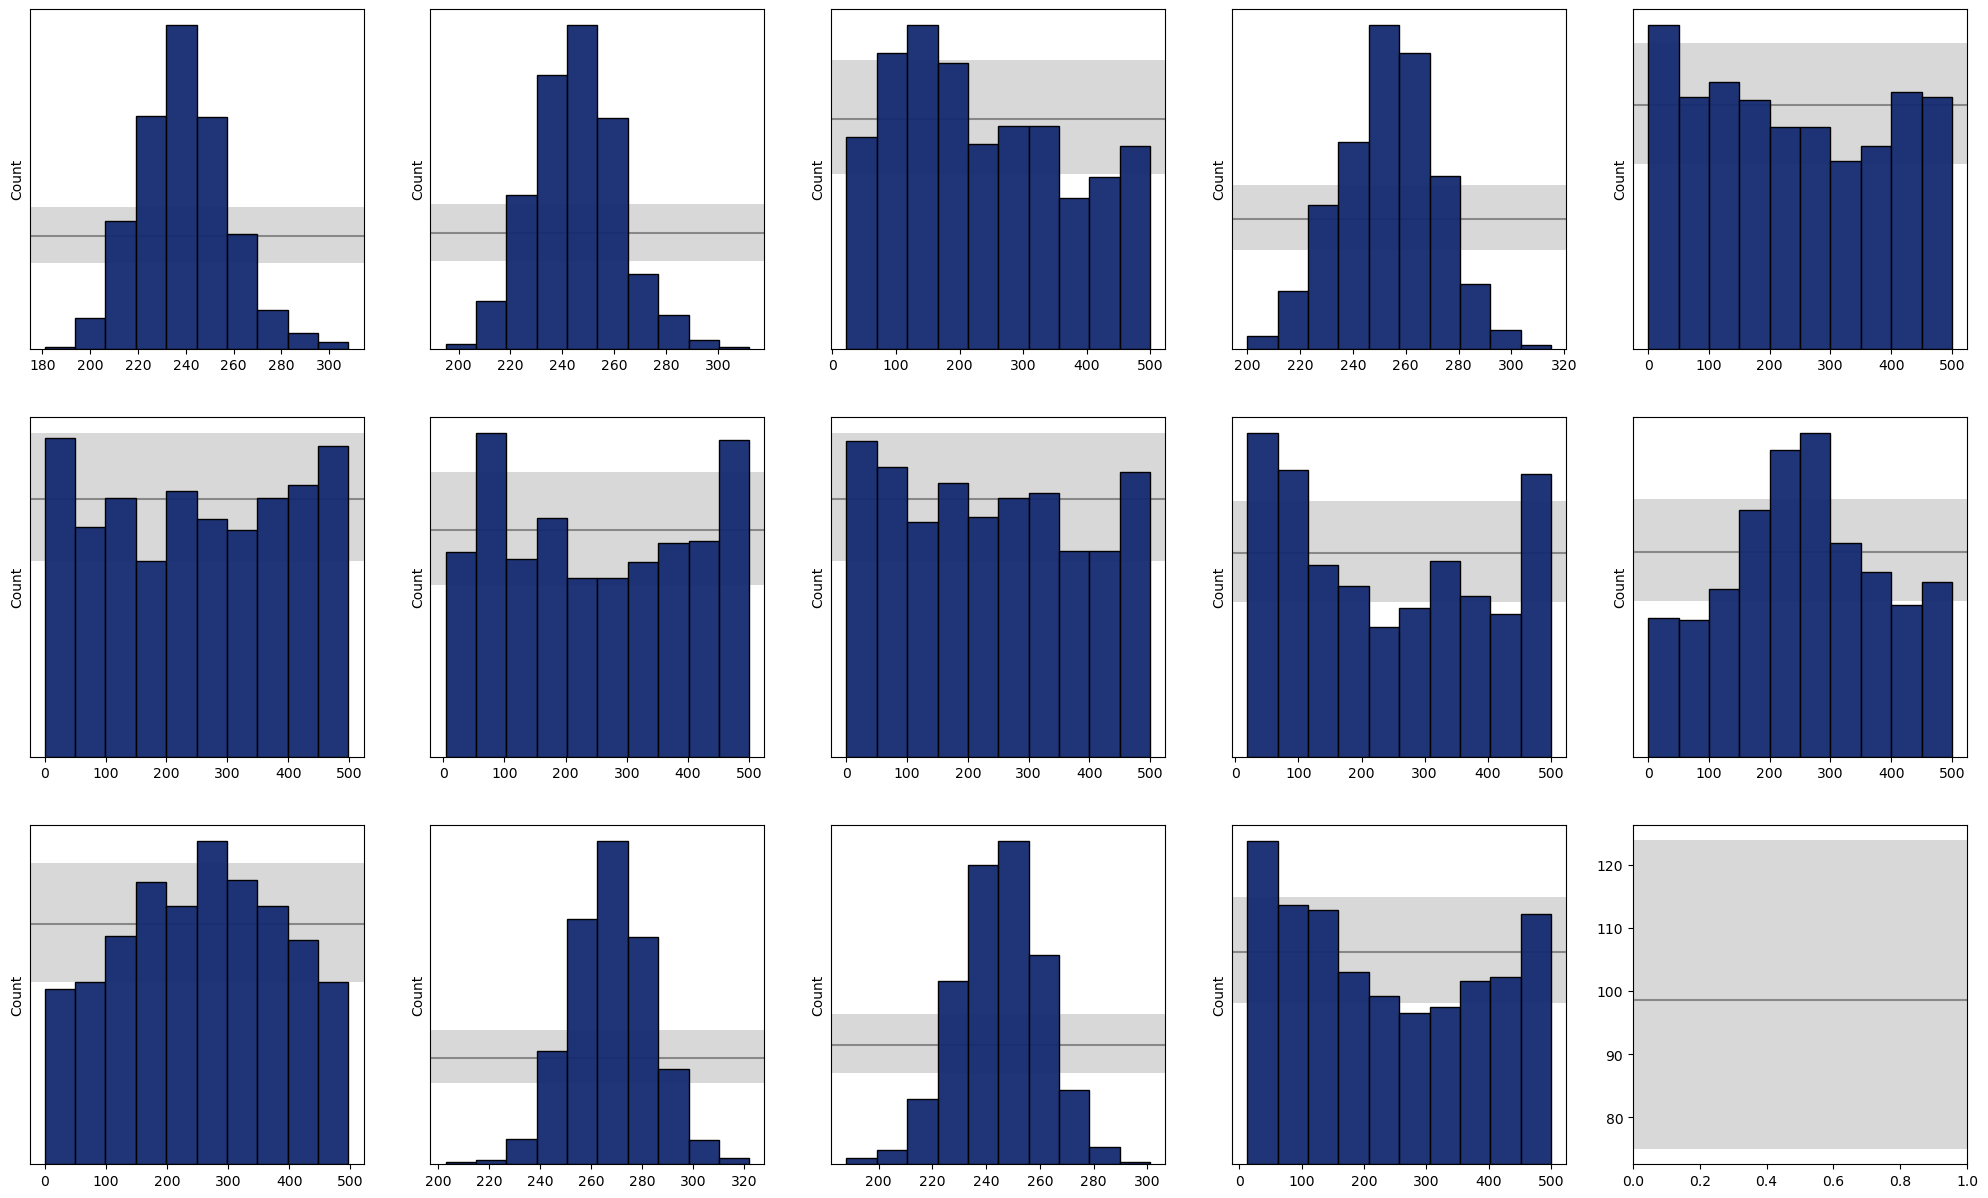

In [18]:
f = bf.diagnostics.plots.calibration_histogram(targets.numpy(),references.numpy())

In [19]:
bf.diagnostics.metrics.calibration_error(targets.numpy(),references.numpy())

{'values': array([0.41512704, 0.44789474, 0.04113644, 0.44789474, 0.03169531,
        0.02947635, 0.0362528 , 0.01115939, 0.05356197, 0.0957804 ,
        0.0594534 , 0.39578947, 0.44789474, 0.05102648]),
 'metric_name': 'Calibration Error',
 'variable_names': None}